This post provides an overview/tutorial about how to change atomic properties (identity, charge, H count, etc.) when providing reactions using reaction SMARTS.

Other sources of information about reaction SMARTS:

- The RDKit book has some [reference material](https://www.rdkit.org/docs/RDKit_Book.html#reaction-smarts) about how reaction SMARTS are handled.
- Phyo Phyo Kyaw Zin wrote a [blog post](https://drzinph.com/learning-reaction-smarts-a-practical-guide-to-reaction-based-patterns/) with an overview of the RDKit's reaction SMARTS and some tips. It's worth a read.

The focus here is on reactions specified using [reaction SMARTS](https://www.rdkit.org/docs/RDKit_Book.html#reaction-smarts) since they are human readable (once you get used to them) and don't take up a lot of space in the notebook, but many of the same rules apply when working with reactions that were specified using other formats like RXN.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdChemReactions

import rdkit
print(rdkit.__version__)

2025.03.1


# Which features are used to match atoms in SMARTS?

The general rule for SMARTS ([as it is for atoms in molecules constructed from SMILES or mol blocks](https://www.rdkit.org/docs/RDKit_Book.html#atom-atom-matching-in-substructure-queries)) is that properties that are not explicitly specified in the query are not used in the matching.

So, the simple `N` query in the SMARTS here matches both atoms:

In [2]:
Chem.MolFromSmiles('NCC[N+](C)(C)C').GetSubstructMatches(Chem.MolFromSmarts('N'))

((0,), (3,))

If we specify a charge on the query N, we only matched the charged atom:

In [3]:
Chem.MolFromSmiles('NCC[N+](C)(C)C').GetSubstructMatches(Chem.MolFromSmarts('[N+]'))

((3,),)

We can also specify that the N must have at least one H neighbor:

In [4]:
Chem.MolFromSmiles('NCC[N+](C)(C)C').GetSubstructMatches(Chem.MolFromSmarts('[N!H0]'))

((0,),)

Or that it have no charge:

In [5]:
Chem.MolFromSmiles('NCC[N+](C)(C)C').GetSubstructMatches(Chem.MolFromSmarts('[N+0]'))

((0,),)

# Specifying changes in reactions

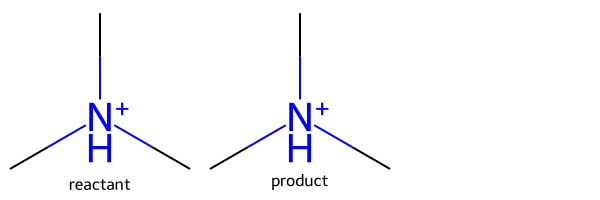

In [6]:
rxn = rdChemReactions.ReactionFromSmarts('[NH+:1]>>[N:1]')
m = Chem.MolFromSmiles('C[NH+](C)C')
ps = rxn.RunReactants((m,))
Draw.MolsToGridImage([m,ps[0][0]],legends=['reactant','product'])

We didn't specify what should change on the right-hand side, so the H-count and charge were preserved.

In order to get those to change, we need to be explicit about the H counts and charge on the product atoms:

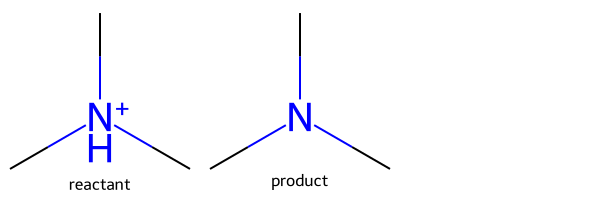

In [7]:
rxn = rdChemReactions.ReactionFromSmarts('[NH+:1]>>[NH0+0:1]')
m = Chem.MolFromSmiles('C[NH+](C)C')
ps = rxn.RunReactants((m,))
Draw.MolsToGridImage([m,ps[0][0]],legends=['reactant','product'])

The atomic properties that can be modified this way are:
1. Charge
2. H count
3. Isotope

Properties which are not specified on the reactant atom, but are specified on the product will also be modified. Here's an example of using that to introduce an isotopic label into a molecule:

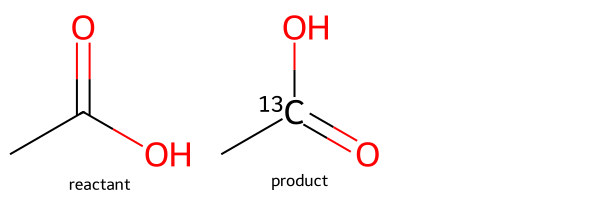

In [12]:
rxn = rdChemReactions.ReactionFromSmarts('[C:1](=[O:2])[O:3]>>[13C:1](=[O:2])[O:3]')
m = Chem.MolFromSmiles('CC(=O)O')
ps = rxn.RunReactants((m,))
Draw.MolsToGridImage([m,ps[0][0]],legends=['reactant','product'])

## Chirality and reactions

As is typical with stereochemistry, things get more complicated if you want to work with chirality in your reactions.


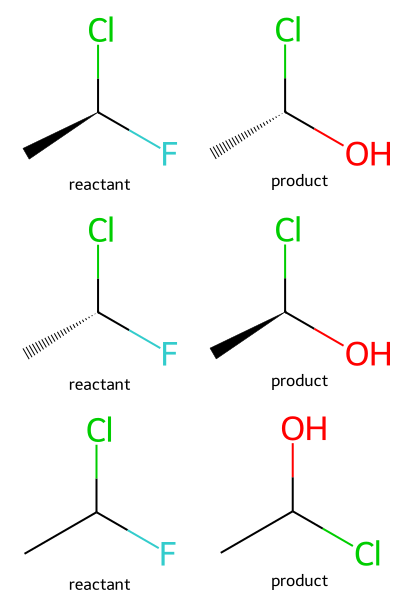

In [8]:
rxn = rdChemReactions.ReactionFromSmarts('[*:1][C@:2][F:3]>>[*:1][C@@:2][O:3]')
m1 = Chem.MolFromSmiles('C[C@H](F)Cl')
ps1 = rxn.RunReactants((m1,))
m2 = Chem.MolFromSmiles('C[C@@H](F)Cl')
ps2 = rxn.RunReactants((m2,))
m3 = Chem.MolFromSmiles('C[CH](F)Cl')
ps3 = rxn.RunReactants((m3,))

Draw.MolsToGridImage([m1,ps1[0][0],m2,ps2[0][0],m3,ps3[0][0]],legends=['reactant','product']*3,molsPerRow=2)


Similarly, if the chiral specification is the same in reactants and in products, then stereochemistry will be preserved:

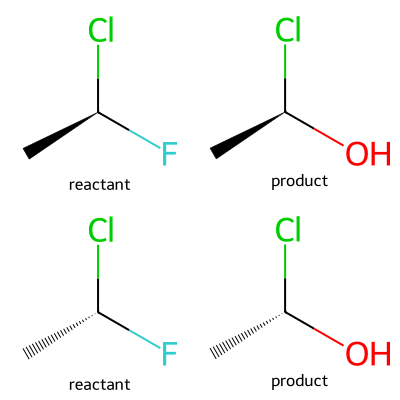

In [44]:
rxn = rdChemReactions.ReactionFromSmarts('[*:1][C@:2][F:3]>>[*:1][C@:2][O:3]')
m1 = Chem.MolFromSmiles('C[C@H](F)Cl')
ps1 = rxn.RunReactants((m1,))
m2 = Chem.MolFromSmiles('C[C@@H](F)Cl')
ps2 = rxn.RunReactants((m2,))

Draw.MolsToGridImage([m1,ps1[0][0],m2,ps2[0][0]],legends=['reactant','product']*2,molsPerRow=2)

Finally, if you want to actually take the chirality into account during the reaction, you can do so by changing the substructure match parameters for the reaction and providing the full coordination environment of the atom to be modified:

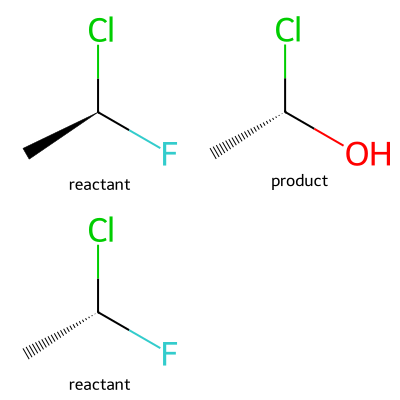

In [9]:
rxn = rdChemReactions.ReactionFromSmarts('[C:1][C@:2]([F:3])[*:4]>>[*:1][C@@:2]([O:3])[*:4]')
ps = rxn.GetSubstructParams()
ps.useChirality = True

m1 = Chem.MolFromSmiles('C[C@H](F)Cl')
ps1 = rxn.RunReactants((m1,))
m2 = Chem.MolFromSmiles('C[C@@H](F)Cl')
ps2 = rxn.RunReactants((m2,))
p2 = ps2[0][0] if ps2 else None

Draw.MolsToGridImage([m1,ps1[0][0],m2,p2],legends=['reactant','product']*2,molsPerRow=2)


Here the second reactant doesn't match since the stereochemistry is wrong.